In [2]:
import numpy as np
np.random.seed(13)

from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter
from gensim.models.doc2vec import Word2Vec

### k.mean( )で必要になるので追加
from keras import backend as K

Using Theano backend.


In [3]:
base_filter()
path = './alice.txt'
corpus = open(path).readlines()[0:5]

### new line more than 2 を削除
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

### base_filter に ' を追加
tokenizer = Tokenizer(filters=base_filter()+"'")

### corpus を整形
tokenizer.fit_on_texts(corpus)

### corpus の型を sequence に変更（file 出力できなかった）
corpus = tokenizer.texts_to_sequences(corpus)

### sequence の合計を nb_samples に代入
nb_samples = sum(len(s) for s in corpus)

### 語彙数を数える
V = len(tokenizer.word_index) + 1

### 多分、特徴ベクトルの次元数
dim = 100

### 文脈窓
window_size = 2

In [4]:
### CBOW の定義
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    
    ### コーパスある単語数だけ繰り返す
    ### 一行ずつ読み込まれる
    for words in corpus:
        
        ### リストを生成
        contexts = []
        labels   = []
        L = len(words)
        
        print "words: ", words
        print ;
        print ;
        
        ### 
        for index, word in enumerate(words):
            s = index-window_size
            e = index+window_size+1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            
            
            ### contexts は文脈窓範囲内の単語の ID が格納されたリスト
            
            print "context: ", contexts[index],
            print type(contexts[index][0])
            print ;
            print ;
            
            
            labels.append(word)
            
            ### x はシーケンス型
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            
            ### 1 of K 表現に変換
            ### y は？
            y = np_utils.to_categorical(labels, V)

            yield (x, y)
        print contexts

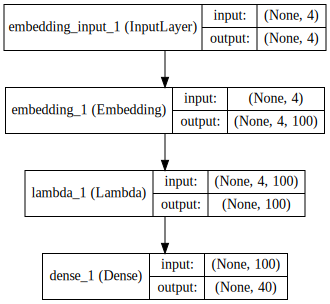

In [5]:
### ネットワーク構造をシーケンシャルに
cbow = Sequential()

### 入力層は Embeddding で固定次元に変換
cbow.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform',input_length=window_size*2))

### 入力層の出力を、dim 次元ベクトルの平均値にする
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))

### dim 次元に変換された 4 つの単語を入力とする第二層
cbow.add(Dense(V, init='glorot_uniform', activation='softmax'))

###  スケーラブル・ベクター・グラフィックを生成、表示
SVG(model_to_dot(cbow, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
### 学習過程の確認
cbow.compile(loss='categorical_crossentropy', optimizer="adadelta")

In [8]:
for x, y in generate_data(corpus, window_size, V):
    
    print "x: "
    print x
    print "y: "
    print y

words:  [7, 5, 8, 15, 8, 37, 18, 19, 33, 12, 14]


context:  [5, 8] <type 'int'>


x: 
[[0 0 5 8]]
y: 
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]
context:  [7, 8, 15] <type 'int'>


x: 
[[ 0  0  5  8]
 [ 0  7  8 15]]
y: 
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]
context:  [7, 5, 15, 8] <type 'int'>


x: 
[[ 0  0  5  8]
 [ 0  7  8 15]
 [ 7  5 15  8]]
y: 
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  

In [7]:
### 学習開始
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow.train_on_batch(x, y)
    print(ite, loss)

words:  [7, 5, 8, 15, 8, 37, 18, 19, 33, 12, 14]


context:  [5, 8] <type 'int'>


context:  [7, 8, 15] <type 'int'>


context:  [7, 5, 15, 8] <type 'int'>


context:  [5, 8, 8, 37] <type 'int'>


context:  [8, 15, 37, 18] <type 'int'>


context:  [15, 8, 18, 19] <type 'int'>


context:  [8, 37, 19, 33] <type 'int'>


context:  [37, 18, 33, 12] <type 'int'>


context:  [18, 19, 12, 14] <type 'int'>


context:  [19, 33, 14] <type 'int'>


context:  [33, 12] <type 'int'>


[[5, 8], [7, 8, 15], [7, 5, 15, 8], [5, 8, 8, 37], [8, 15, 37, 18], [15, 8, 18, 19], [8, 37, 19, 33], [37, 18, 33, 12], [18, 19, 12, 14], [19, 33, 14], [33, 12]]
words:  [36, 29, 13, 20, 2, 3, 6, 22, 38, 17, 4, 16, 9, 32]


context:  [29, 13] <type 'int'>


context:  [36, 13, 20] <type 'int'>


context:  [36, 29, 20, 2] <type 'int'>


context:  [29, 13, 2, 3] <type 'int'>


context:  [13, 20, 3, 6] <type 'int'>


context:  [20, 2, 6, 22] <type 'int'>


context:  [2, 3, 22, 38] <type 'int'>


context:  [3, 6, 38, 17] <t

In [23]:
### 書き込み用ファイルを生成
f = open("vectors.txt", "w")

### 語彙数と特徴ベクトルの次元数を書き込む
f.write( " ".join([str(V-1), str(dim)]) )
f.write("\n")

In [24]:
vectors = cbow.get_weights()[0]

### 学習で得られた単語の特徴ベクトルを書き込む
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [25]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [26]:
w2v.most_similar(positive=['alice'])

[(u'anywhere', 0.24575386941432953),
 (u'project', 0.14913886785507202),
 (u'adventures', 0.13993321359157562),
 (u'anyone', 0.1208343505859375),
 (u'included', 0.1158161386847496),
 (u'use', 0.10622011125087738),
 (u'carroll', 0.10004357248544693),
 (u'of', 0.09992651641368866),
 (u'gutenberg', 0.060956358909606934),
 (u'with', 0.0600891076028347)]